In [1]:
import pandas as pd
import numpy as np

from d2m.checker import duplicateCheck, VCSummary, VCCheck

import plotly
import plotly.offline as py
import plotly.express as px
from plotly.graph_objs import Figure
import pickle as pkl
import random

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from keras.utils import np_utils

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.metrics import accuracy_score
from sklearn import preprocessing

from packaging import version
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >= 2, \
    "This notebook requires TensorFlow 2.0 or above."


from numpy.random import seed
random_seed = 2021
seed(random_seed)
tf.random.set_seed(random_seed)

TensorFlow version:  2.3.1


In [3]:
def analize(y_pred, y_true, modelName='', n_classes = 2):
    # ROC, AUC
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    
    trace1 = {
      'name': f'Status = good, auc={auc(fpr[0], tpr[0]):.2f}', 
      'type': 'scatter', 
      'x': fpr[0], 
      'y': tpr[0]
    }
    trace2 = {
      'name': f'Status = bad, auc={auc(fpr[1], tpr[1]):.2f}', 
      'type': 'scatter', 
      'x': fpr[1], 
      'y': tpr[1]
    }

    data = [trace1, trace2]
    layout = {
      'shapes': [{'line': {'dash': 'dash'}, 'type': 'line', 'x0': 0, 'x1': 1, 'y0': 0, 'y1': 1}],
      'title': f'ROC curve {modelName}', 
      'xaxis': {
        'title': 'false positive rate', 
        'zeroline': False
      }, 
      'yaxis': {
        'title': 'true positive rate', 
        'zeroline': False,
      },
      'width':650,
      'height':500,
    }

    fig = Figure(data=data, layout=layout)
    py.iplot(fig, validate = False)
    
    # confusion matrix
    y_pred_cat = np.argmax(y_pred.round(), axis = 1)
    y_true_cat = np.argmax(y_true, axis = 1)
    print(f'accuracy_score: {accuracy_score(y_true_cat, y_pred_cat)}')

    cm = pd.DataFrame(confusion_matrix(y_pred_cat, y_true_cat))
    cm.columns = ['true 0', 'true 1']
    cm.index = ['pred 0', 'pred 1']
    
    TP, FP = cm.iloc[0,0], cm.iloc[0,1]
    FN, TN = cm.iloc[1,0], cm.iloc[1,1]
    
    
    sensitivity = TP/(TP+FN)
    recall = sensitivity
    specificity = TN/(FP+TN)
    precision = TP/(TP+FP)    
    accuracy = (TP+TN)/(TP+FP+FN+TN)
    f1score = 2/(1/precision+1/recall)
    
    summary = pd.DataFrame({'metric':['Sensitivity', 'Recall', 'Specificity', 'Precision', 'Accuracy', 'F1Score'], 
                            'value':[sensitivity, recall, specificity, precision, accuracy, f1score]})
    return cm, summary

In [4]:
def plotHistory(history, col):
    trace1 = {
      'name': f'{col}', 
      'type': 'scatter', 
      'x': list(range(len(history[f'{col}']))), 
      'y': history[f'{col}']
    }
    trace2 = {
      'name': f'val_{col}', 
      'type': 'scatter', 
      'x': list(range(len(history[f'val_{col}']))), 
      'y': history[f'val_{col}']
    }

    data = [trace1, trace2]
    layout = {
      'title': f'history of {col} vs vol_{col}', 
      'xaxis': {
        'title': 'false positive rate', 
        'zeroline': False
      }, 
      'yaxis': {
        'title': 'true positive rate', 
        'zeroline': False,
      },
    }

    fig = Figure(data=data, layout=layout)
    py.iplot(fig, validate = False)
    
def printHistory(history):
    h = history
    print(f"loss:{h['loss'][-1]:.4e} accuracy:{h['accuracy'][-1]:.4e} val_loss:{h['val_loss'][-1]:.4e} val_accuracy:{h['val_accuracy'][-1]:.4e}")

In [5]:
df = pd.read_csv('german.data',header = None, sep = ' ')
df.columns = ['ExistingAccountStatus','MonthDuration','CreditHistory','Purpose','CreditAmount','SavingAcount','PresentEmployment','InstalmentRate','Sex','Guarantors','Residence','Property','Age','Installment','Housing','ExistingCredits','Job','NumPeople','Telephone','ForeignWorker','Status']
categoricalFeatures=['ExistingAccountStatus','CreditHistory','Purpose','SavingAcount', 'PresentEmployment', 'Sex','Guarantors','Property','Installment','Housing','Job','Telephone','ForeignWorker']

dfEncode = df.copy()
dfDetail = df.copy()

df.head(5)

ExistingAccountStatus  MonthDuration CreditHistory Purpose  CreditAmount  \
0                   A11              6           A34     A43          1169   
1                   A12             48           A32     A43          5951   
2                   A14             12           A34     A46          2096   
3                   A11             42           A32     A42          7882   
4                   A11             24           A33     A40          4870   

  SavingAcount PresentEmployment  InstalmentRate  Sex Guarantors  ...  \
0          A65               A75               4  A93       A101  ...   
1          A61               A73               2  A92       A101  ...   
2          A61               A74               2  A93       A101  ...   
3          A61               A74               2  A93       A103  ...   
4          A61               A73               3  A93       A101  ...   

   Property Age  Installment Housing ExistingCredits   Job NumPeople  \
0      A121  67         A143    A152               2  A173         1   
1      A121  22         A143    A152               1  A173         1   
2      A121  49         A143    A152               1  A172         2   
3      A122  45         A143    A153               1  A173         2   
4      A124  53         A143    A153               2  A173         2   

   Telephone ForeignWorker Status  
0       A192          A201      1  
1       A191          A201      2  
2       A191          A201      1  
3       A191          A201      1  
4       A191          A201      2  

[5 rows x 21 columns]

In [6]:
labelEncoder = preprocessing.LabelEncoder()
for x in categoricalFeatures:
    dfEncode[x] = labelEncoder.fit_transform(dfEncode[x])

dfEncode['Status'] = labelEncoder.fit_transform(dfEncode['Status']) # {1:0, 2:1}
onehotStatus = np_utils.to_categorical(dfEncode['Status'])
dfEncode.head(5)

ExistingAccountStatus  MonthDuration  CreditHistory  Purpose  CreditAmount  \
0                      0              6              4        4          1169   
1                      1             48              2        4          5951   
2                      3             12              4        7          2096   
3                      0             42              2        3          7882   
4                      0             24              3        0          4870   

   SavingAcount  PresentEmployment  InstalmentRate  Sex  Guarantors  ...  \
0             4                  4               4    2           0  ...   
1             0                  2               2    1           0  ...   
2             0                  3               2    2           0  ...   
3             0                  3               2    2           2  ...   
4             0                  2               3    2           0  ...   

   Property  Age  Installment  Housing  ExistingCredits  Job  NumPeople  \
0         0   67            2        1                2    2          1   
1         0   22            2        1                1    2          1   
2         0   49            2        1                1    1          2   
3         1   45            2        2                1    2          2   
4         3   53            2        2                2    2          2   

   Telephone  ForeignWorker  Status  
0          1              0       0  
1          0              0       1  
2          0              0       0  
3          0              0       0  
4          0              0       1  

[5 rows x 21 columns]

# 檢查資料量是否足夠

In [7]:
VCSummary(dfEncode, dvc = 100, epsilon=0.05, delta=0.05)

number of     type  log(bound)   amount model learnable
0                  data samples                  NaN     1000             NaN
1              model parameters                  NaN      100             NaN
2  experienced bound of samples      exp  330.392560     1000           False
3      general bound of samples  general  318.205060  1000000           False
4        loose bound of samples    loose   -1.300911  2127326           False

#### <font color=brik>小結</font>
對模型參數量 > 100 的 model，目前 1000 筆的 dataset 並不足以支撐訓練這樣的模型。故先選擇 NN 作為 feature transform 後的分類器當作 baselien。接下來選擇以較容易 overfitting 的模型 random-forest 以及 SVC 做為分類器，最終再 ensemble 這兩個 model 以盡量消減 model bias。

# Check on PCA

In [8]:
from sklearn.decomposition import PCA
X = dfEncode.drop(['Status'], axis=1)
#y =np_utils.to_categorical(dfEncode.Status)
pca = PCA(n_components=8)
pca.fit(X)
components = pca.fit_transform(X)
components = pd.DataFrame(components[:,0:2], columns=['PCA0', 'PCA1'])
components.loc[:,'Status'] = dfEncode.Status
components.Status = components.Status.apply(lambda x: 'Bad' if x  else 'Good')

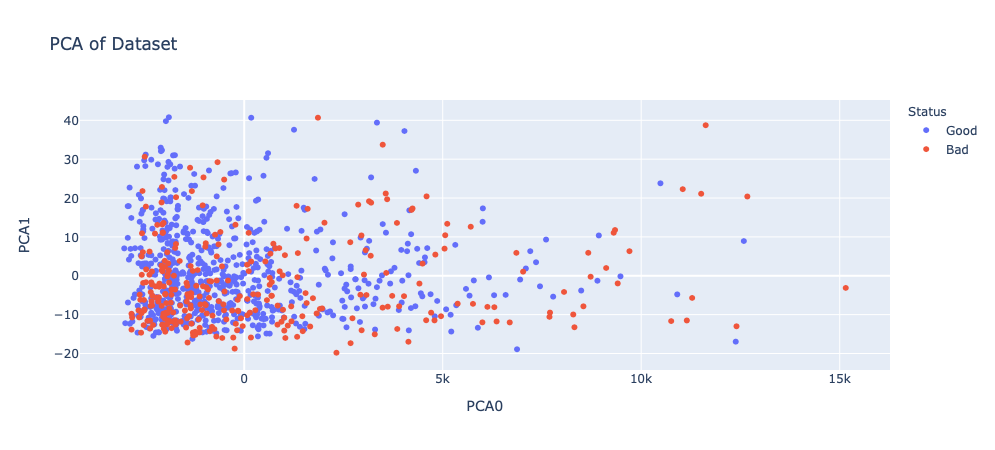

In [9]:
df = px.data.iris() # iris is a pandas DataFrame
fig = px.scatter(components, x='PCA0', y='PCA1', color='Status', title='PCA of Dataset')
fig.show()

#### <font color=brik>小結</font>
做完 PCA 發現 Status 的 Good、Bad 還是有一堆擠在一起，表示即使變異最大的兩軸仍難以分開，因此肯定需要做高維度的 feature transform 才有可能分得好。

# 實驗紀錄宣告

In [10]:
test_summary = dict()
train_summary = dict()

## DNN 分類器

In [11]:
X_train, X_test, y_train, y_test = train_test_split(dfEncode.drop(['Status'], axis=1), onehotStatus, 
                                                    test_size=0.2, 
                                                    random_state=random_seed)

X_train_detail = dfDetail.iloc[X_train.index,]
X_test_detail = dfDetail.iloc[X_test.index,]

scaler = preprocessing.StandardScaler().fit(X_train)
scaler.mean_, scaler.scale_

X_train_ = scaler.transform(X_train)
X_test_ = scaler.transform(X_test)

In [12]:
def NN(dim, mute=True):
    input = tf.keras.Input(shape=(20, ), name='input')
    DNN1 = keras.layers.Dense(16, activation='relu', name='dnn1')(input)
    DNN2 = keras.layers.Dense(8, activation='relu', name='dnn2')(DNN1)
    #DNN3 = keras.layers.Dense(5, activation='softmax', name='dnn3')(DNN2)
    output = keras.layers.Dense(2, activation='softmax', name='output')(DNN2)
    
    model = keras.Model(input, output)

    model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics=['accuracy'])
    if not mute: print(model.summary())
    
    return model

In [13]:
dnn = NN(20, False)

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 20)]              0         
_________________________________________________________________
dnn1 (Dense)                 (None, 16)                336       
_________________________________________________________________
dnn2 (Dense)                 (None, 8)                 136       
_________________________________________________________________
output (Dense)               (None, 2)                 18        
Total params: 490
Trainable params: 490
Non-trainable params: 0
_________________________________________________________________
None


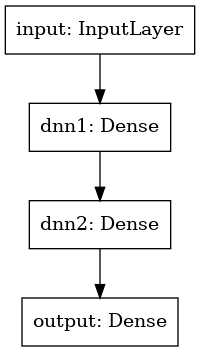

In [14]:
tf.keras.utils.plot_model(dnn, './dnn.png')

In [15]:
dnnHistory = dnn.fit(X_train_, y_train, 
                     validation_data=(X_test_, y_test),
                     batch_size=4, 
                     epochs=400, 
                     verbose=False)
printHistory(dnnHistory.history)

loss:7.6713e-04 accuracy:1.0000e+00 val_loss:5.8721e+00 val_accuracy:7.0500e-01


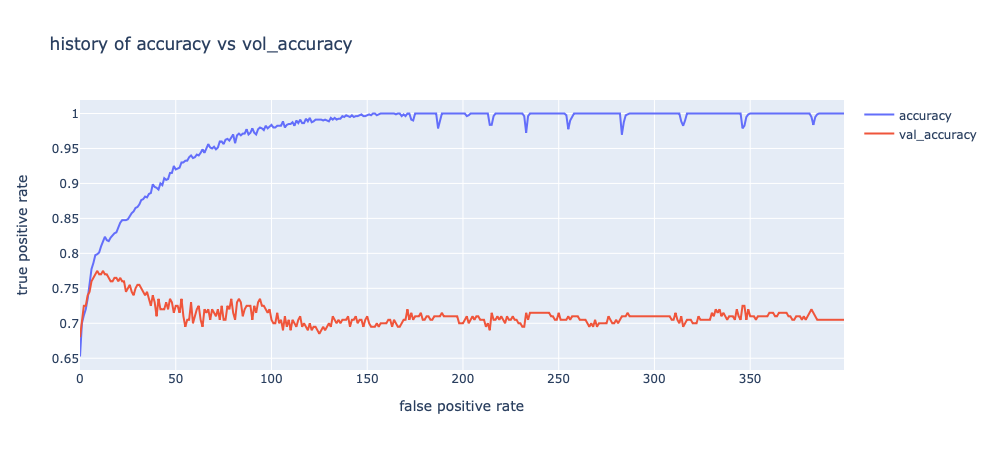

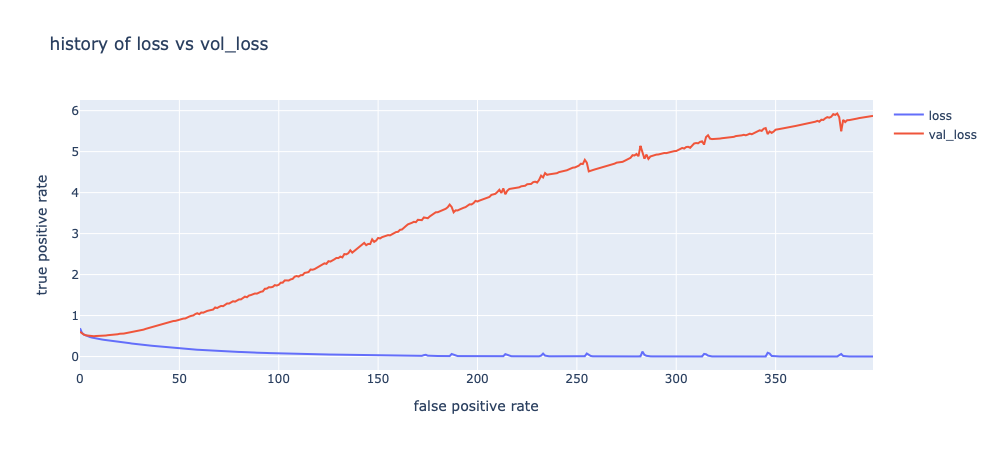

In [16]:
plotHistory(dnnHistory.history, 'accuracy')
plotHistory(dnnHistory.history, 'loss')

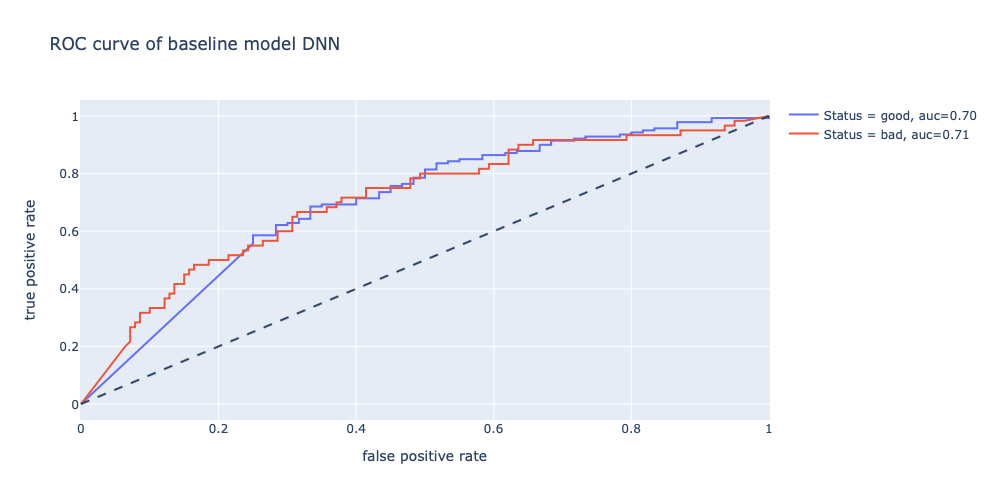

accuracy_score: 0.705


In [17]:
y_pred = dnn.predict(X_test_)#.round()
cm, summary = analize(y_pred, y_test, 'of baseline model DNN')
test_summary['dnn'] = summary.copy()

In [18]:
cm

true 0  true 1
pred 0     111      30
pred 1      29      30

In [19]:
summary

metric     value
0  Sensitivity  0.792857
1       Recall  0.792857
2  Specificity  0.500000
3    Precision  0.787234
4     Accuracy  0.705000
5      F1Score  0.790036

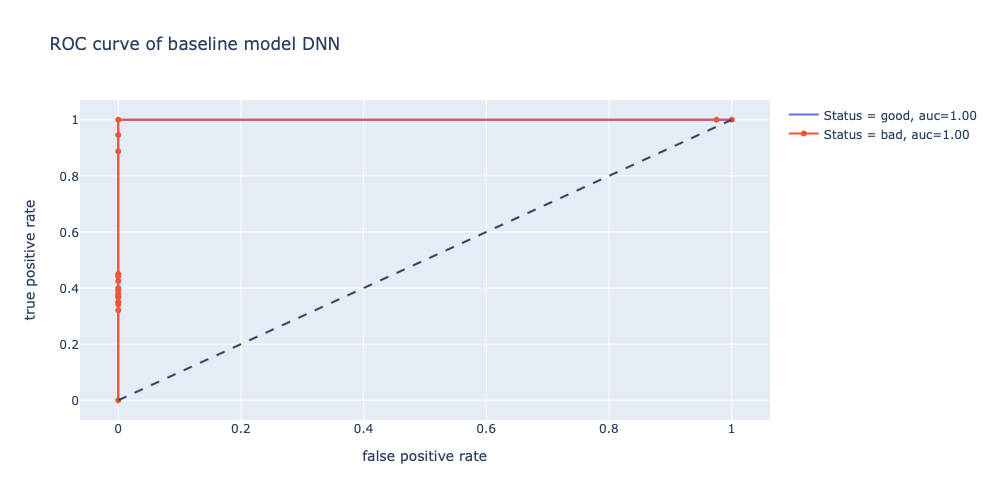

accuracy_score: 1.0


In [20]:
y_pred = dnn.predict(X_train_)#.round()
cm, summary = analize(y_pred, y_train, 'of baseline model DNN')
train_summary['dnn'] = summary.copy()

In [21]:
cm

true 0  true 1
pred 0     560       0
pred 1       0     240

In [22]:
summary

metric  value
0  Sensitivity    1.0
1       Recall    1.0
2  Specificity    1.0
3    Precision    1.0
4     Accuracy    1.0
5      F1Score    1.0

# SVC

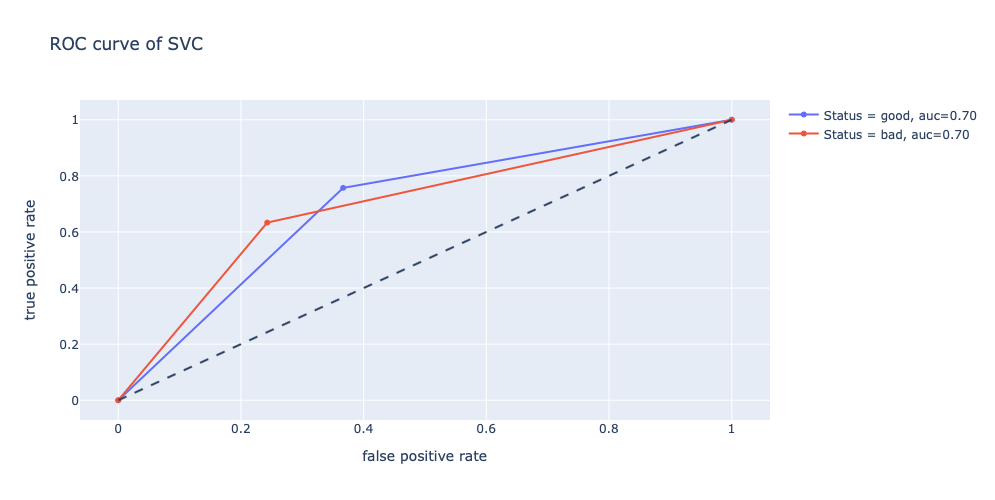

accuracy_score: 0.72


In [23]:
from sklearn.svm import SVC
svc = SVC(gamma='auto', class_weight = 'balanced')
svc.fit(X_train_, np.argmax(y_train, axis = 1))

y_pred = np_utils.to_categorical(svc.predict(X_test_))
cm, summary = analize(y_pred, y_test, 'of SVC')
test_summary['svc'] = summary.copy()

In [24]:
cm

true 0  true 1
pred 0     106      22
pred 1      34      38

In [25]:
summary

metric     value
0  Sensitivity  0.757143
1       Recall  0.757143
2  Specificity  0.633333
3    Precision  0.828125
4     Accuracy  0.720000
5      F1Score  0.791045

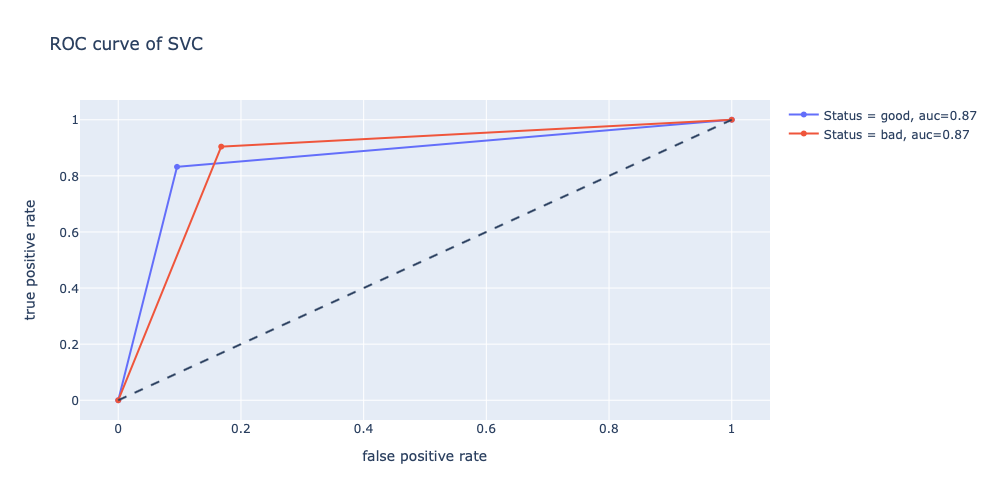

accuracy_score: 0.85375


In [26]:
y_pred = np_utils.to_categorical(svc.predict(X_train_))
cm, summary = analize(y_pred, y_train, 'of SVC')
train_summary['svc'] = summary.copy()

In [27]:
cm

true 0  true 1
pred 0     466      23
pred 1      94     217

In [28]:
summary

metric     value
0  Sensitivity  0.832143
1       Recall  0.832143
2  Specificity  0.904167
3    Precision  0.952965
4     Accuracy  0.853750
5      F1Score  0.888465

# Random forest

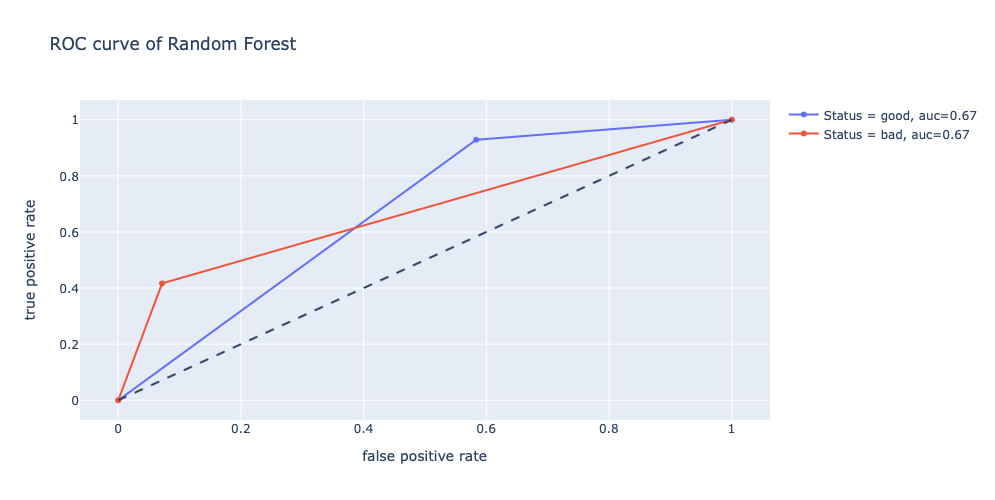

accuracy_score: 0.775


In [29]:
from sklearn.ensemble import RandomForestClassifier
randomforest = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=1234)
randomforest.fit(X_train, y_train)

y_pred = randomforest.predict(X_test)
cm, summary = analize(y_pred, y_test, 'of Random Forest')
test_summary['randomforest'] = summary.copy()

In [30]:
cm

true 0  true 1
pred 0     130      35
pred 1      10      25

In [31]:
summary

metric     value
0  Sensitivity  0.928571
1       Recall  0.928571
2  Specificity  0.416667
3    Precision  0.787879
4     Accuracy  0.775000
5      F1Score  0.852459

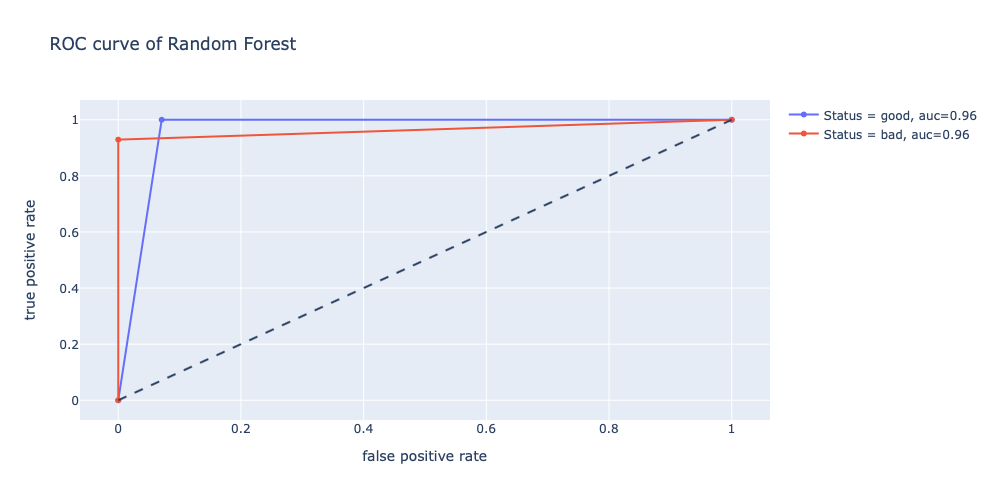

accuracy_score: 0.97875


In [32]:
y_pred = randomforest.predict(X_train)
cm, summary = analize(y_pred, y_train, 'of Random Forest')
train_summary['randomforest'] = summary.copy()

In [33]:
cm

true 0  true 1
pred 0     560      17
pred 1       0     223

In [34]:
summary

metric     value
0  Sensitivity  1.000000
1       Recall  1.000000
2  Specificity  0.929167
3    Precision  0.970537
4     Accuracy  0.978750
5      F1Score  0.985048

# XGBoost 

[02:17:23] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


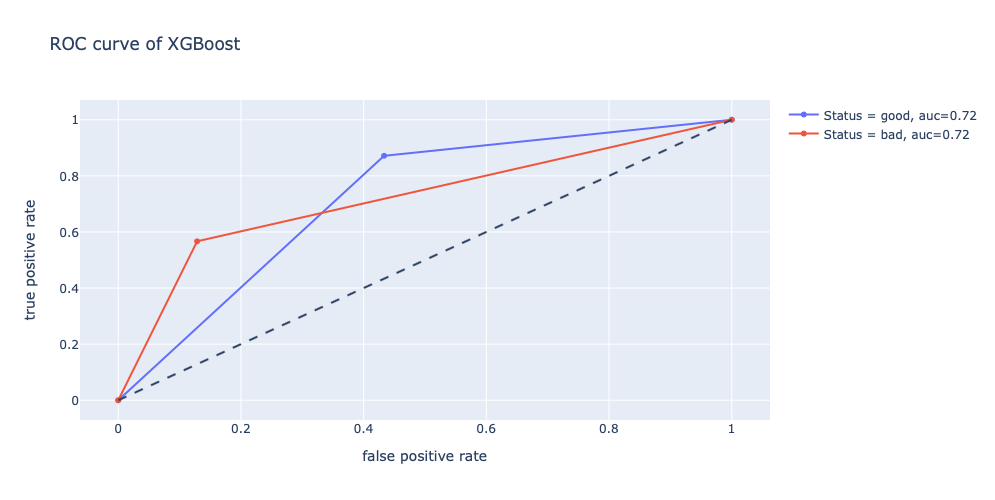

accuracy_score: 0.78


In [35]:
from xgboost import XGBClassifier
xgb = XGBClassifier(use_label_encoder=False)
xgb.fit(X_train, np.argmax(y_train, axis = 1))

y_pred = np_utils.to_categorical(xgb.predict(X_test))
cm, summary = analize(y_pred, y_test, 'of XGBoost')
test_summary['xgb'] = summary.copy()

In [36]:
cm

true 0  true 1
pred 0     122      26
pred 1      18      34

In [37]:
summary

metric     value
0  Sensitivity  0.871429
1       Recall  0.871429
2  Specificity  0.566667
3    Precision  0.824324
4     Accuracy  0.780000
5      F1Score  0.847222

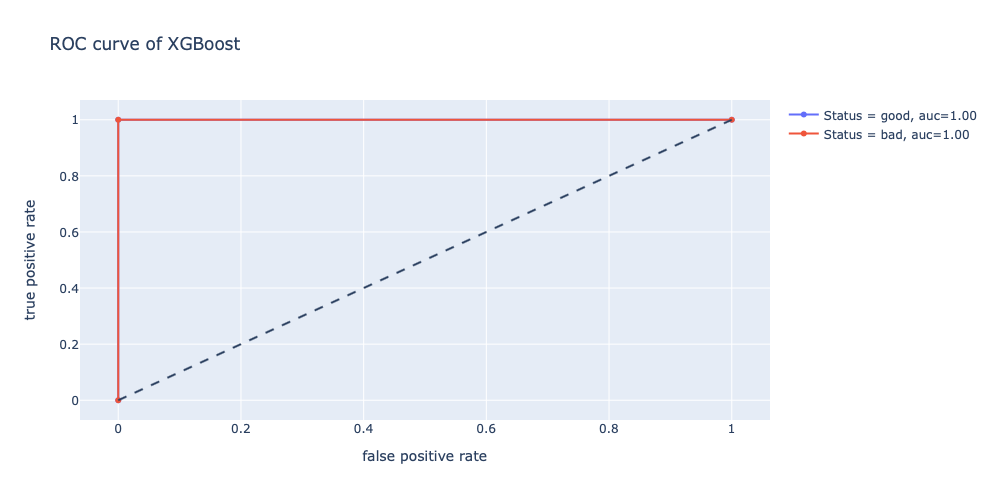

accuracy_score: 1.0


In [38]:
y_pred = np_utils.to_categorical(xgb.predict(X_train))
cm, summary = analize(y_pred, y_train, 'of XGBoost')
train_summary['xgb'] = summary.copy()

In [39]:
cm

true 0  true 1
pred 0     560       0
pred 1       0     240

In [40]:
summary

metric  value
0  Sensitivity    1.0
1       Recall    1.0
2  Specificity    1.0
3    Precision    1.0
4     Accuracy    1.0
5      F1Score    1.0

# Decision Tree

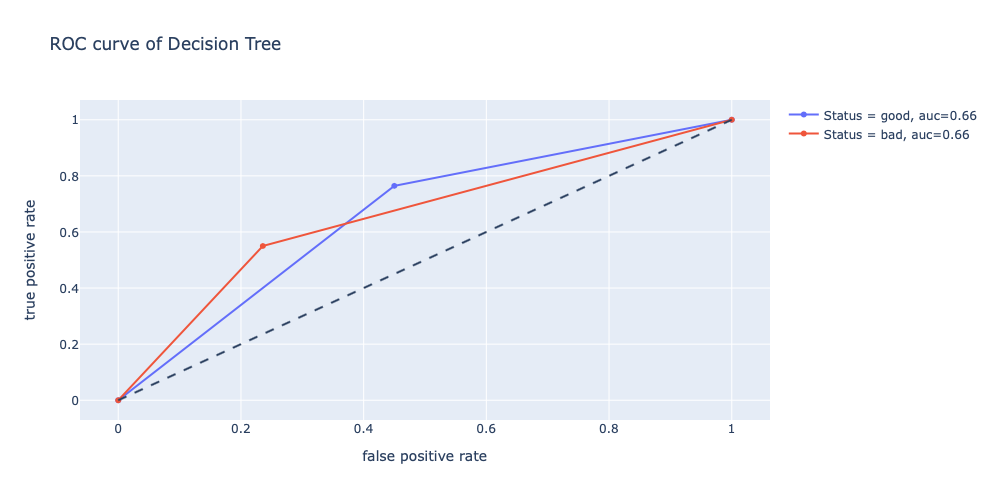

accuracy_score: 0.7


In [41]:
from sklearn import tree
decisiontree = tree.DecisionTreeClassifier()
decisiontree = decisiontree.fit(X_train, y_train)

y_pred = decisiontree.predict(X_test)
cm, summary = analize(y_pred, y_test, 'of Decision Tree')
test_summary['decisiontree'] = summary.copy()

In [42]:
cm

true 0  true 1
pred 0     107      27
pred 1      33      33

In [43]:
summary

metric     value
0  Sensitivity  0.764286
1       Recall  0.764286
2  Specificity  0.550000
3    Precision  0.798507
4     Accuracy  0.700000
5      F1Score  0.781022

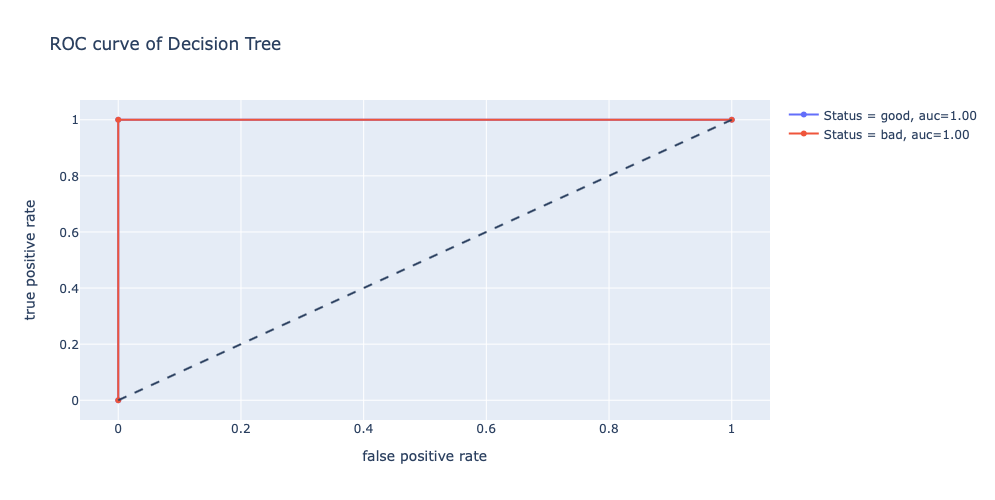

accuracy_score: 1.0


In [44]:
y_pred = decisiontree.predict(X_train)
cm, summary = analize(y_pred, y_train, 'of Decision Tree')
train_summary['decisiontree'] = summary.copy()

In [45]:
cm

true 0  true 1
pred 0     560       0
pred 1       0     240

In [46]:
summary

metric  value
0  Sensitivity    1.0
1       Recall    1.0
2  Specificity    1.0
3    Precision    1.0
4     Accuracy    1.0
5      F1Score    1.0

# 各種 model 在 testing set 上的比較

# Ensemble

In [47]:
def ensemble(models, Xs, onehots):
    y_pred = None
    i = 0
    for ((name, model), X, onehot) in zip(models.items(), Xs, onehots):
        print(name, onehot)
        if y_pred is None:
            pred = model.predict(X)
            y_pred = np_utils.to_categorical(pred) if onehot else pred
        else:   
            pred = model.predict(X)
            y_pred += np_utils.to_categorical(pred) if onehot else pred
    y_pred = y_pred/len(models)
    return y_pred

dnn False
svc True


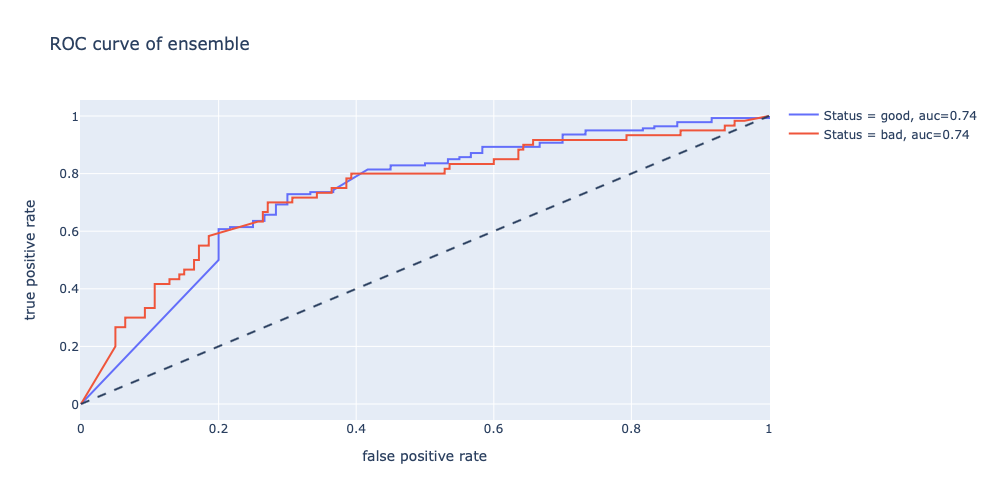

accuracy_score: 0.745


In [48]:
y_pred = ensemble({'dnn':dnn, 
                   'svc':svc}, 
                  [X_test_, X_test_], 
                  [False, True])
cm, summary = analize(y_pred, y_test, 'of ensemble')
test_summary['dnn+svc'] = summary.copy()

In [49]:
cm

true 0  true 1
pred 0     114      25
pred 1      26      35

In [50]:
summary

metric     value
0  Sensitivity  0.814286
1       Recall  0.814286
2  Specificity  0.583333
3    Precision  0.820144
4     Accuracy  0.745000
5      F1Score  0.817204

dnn False
svc True
rforest False


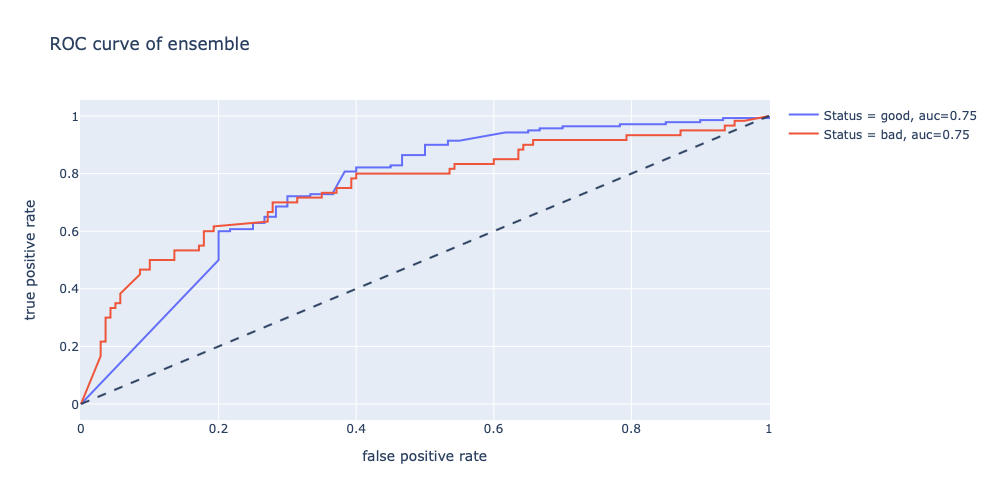

accuracy_score: 0.755


In [51]:
y_pred = ensemble({'dnn':dnn, 
                   'svc':svc, 
                   'rforest':randomforest}, 
                  [X_test_, X_test_, X_test], 
                  [False, True, False])
cm, summary = analize(y_pred, y_test, 'of ensemble')
test_summary['dnn+svc+rforest'] = summary.copy()

In [52]:
cm

true 0  true 1
pred 0     119      28
pred 1      21      32

In [53]:
summary

metric     value
0  Sensitivity  0.850000
1       Recall  0.850000
2  Specificity  0.533333
3    Precision  0.809524
4     Accuracy  0.755000
5      F1Score  0.829268

dnn False
svc True
rforest False
dtree False


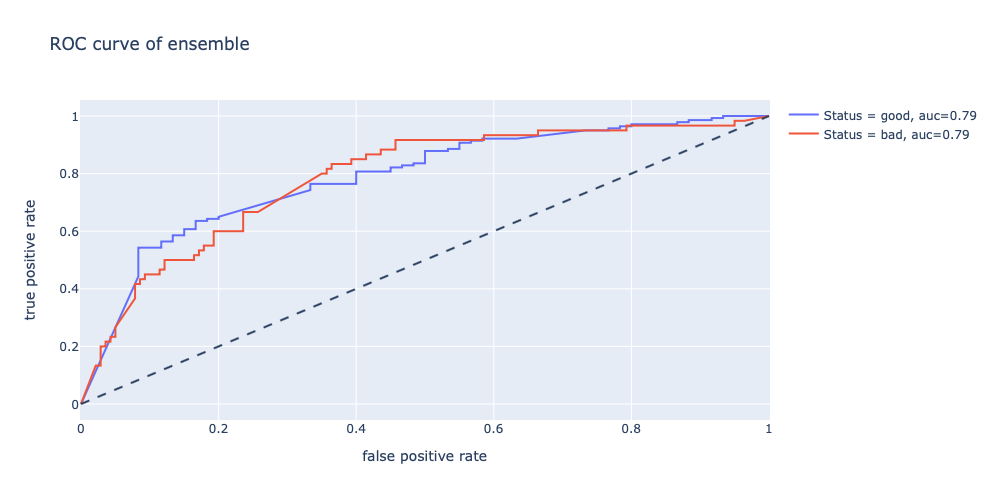

accuracy_score: 0.765


In [54]:
y_pred = ensemble({'dnn':dnn, 
                   'svc':svc, 
                   'rforest':randomforest, 
                   'dtree':decisiontree}, 
                  [X_test_, X_test_, X_test, X_test], 
                  [False, True, False, False])
cm, summary = analize(y_pred, y_test, 'of ensemble')
test_summary['dnn+svc+rforest+dtree'] = summary.copy()

In [55]:
cm

true 0  true 1
pred 0     123      30
pred 1      17      30

In [56]:
summary

metric     value
0  Sensitivity  0.878571
1       Recall  0.878571
2  Specificity  0.500000
3    Precision  0.803922
4     Accuracy  0.765000
5      F1Score  0.839590

dnn False
svc True
rforest False
xgb True
dtree False


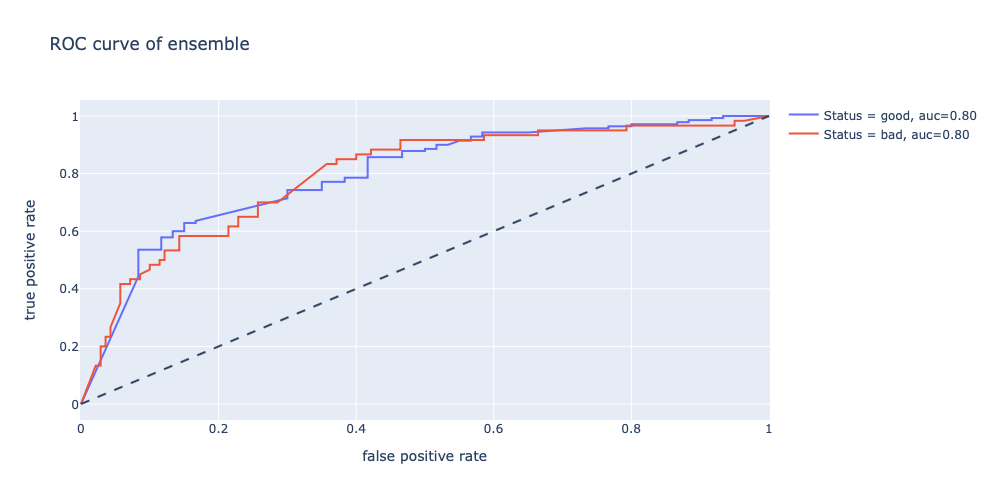

accuracy_score: 0.765


In [57]:
y_pred = ensemble({'dnn':dnn, 
                   'svc':svc, 
                   'rforest':randomforest, 
                   'xgb':xgb,
                   'dtree':decisiontree}, 
                  [X_test_, X_test_, X_test, X_test, X_test], 
                  [False, True, False, True, False])
cm, summary = analize(y_pred, y_test, 'of ensemble')
test_summary['dnn/svc/rforest/dtree/xgb'] = summary.copy()

In [58]:
cm

true 0  true 1
pred 0     121      28
pred 1      19      32

In [59]:
summary

metric     value
0  Sensitivity  0.864286
1       Recall  0.864286
2  Specificity  0.533333
3    Precision  0.812081
4     Accuracy  0.765000
5      F1Score  0.837370

# Check test summary

In [60]:
pkl.dump(test_summary, open('test_summary.pkl', 'wb'))

# Check false class 0 samples

In [61]:
ys = pd.DataFrame({'pred':np.argmax(y_pred, axis=1), 'true':np.argmax(y_test, axis=1)})
y_false0 = ys[(ys.pred!=ys.true) & (ys.pred==0)]
y_false1 = ys[(ys.pred!=ys.true) & (ys.pred==1)]

X_false0 = X_test.reset_index(drop=True).iloc[y_false0.index,:]
X_false1 = X_test.reset_index(drop=True).iloc[y_false1.index,:]

X_false0['Status'] = 2
X_false1['Status'] = 1

X_false = pd.concat([X_false0, X_false1])


X_false0_detail = X_test_detail.reset_index(drop=True).iloc[y_false0.index,:]
X_false1_detail = X_test_detail.reset_index(drop=True).iloc[y_false1.index,:]

X_false0_detail['Status'] = 2
X_false1_detail['Status'] = 1

X_false_detail = pd.concat([X_false0_detail, X_false1_detail])

In [62]:
pkl.dump(X_false, open('X_false.pkl', 'wb'))
pkl.dump(X_false_detail, open('X_false_detail.pkl', 'wb'))

# Bagging

In [63]:
def bagging(X_train, y_train, X_test, y_test, n=10, models=['dnn', 'svc', 'rforest', 'xgb', 'dtree'], frac=0.75):
    df = X_train.copy()
    df[0] = y_train[:,0]
    df[1] = y_train[:,1]
    
    ys = []
    #onehots = []
    dnnInfo = []
    while (n :=n-1) >= 0:
        X_train = df.sample(frac=frac)
        y_train = X_train[[0, 1]].values
        X_train = X_train.drop([0, 1], axis=1)
        X_train_ = scaler.transform(X_train)

        for model in models:
            if model == 'dnn':
                tf.random.set_seed(random_seed+random.randint(1,1000000))
                m = NN(20)
                
                mHistory = m.fit(X_train_, y_train, 
                                 validation_data=(X_test_, y_test),
                                 batch_size=4, 
                                 epochs=int(400*frac), 
                                 verbose=False)
                dnnInfo.append(pd.DataFrame({'loss':mHistory.history['loss'], 
                                             'accuracy':mHistory.history['accuracy'], 
                                             'val_loss':mHistory.history['val_loss'], 
                                             'val_accuracy':mHistory.history['val_accuracy']}))
                ys.append(m.predict(X_test_))
                
            elif model == 'svc':
                m = SVC(gamma='auto', degree=3)
                m.fit(X_train_, np.argmax(y_train, axis = 1))
                ys.append(np_utils.to_categorical(m.predict(X_test_)))

            elif model == 'rforest':
                m = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=1234)
                m.fit(X_train, y_train)
                ys.append(m.predict(X_test))

            elif model == 'xgb':
                m = XGBClassifier(use_label_encoder=False)
                m.fit(X_train, np.argmax(y_train, axis = 1))
                ys.append(np_utils.to_categorical(m.predict(X_test)))
                
            elif model == 'dtree':
                m = tree.DecisionTreeClassifier()
                m.fit(X_train, y_train)
                ys.append(m.predict(X_test))

    return ys, dnnInfo

def avgYs(ys):
    y_pred = None
    for y in ys:
        if y_pred is None:
            y_pred = y
        else:
            y_pred += y
    else:
        y_pred = y_pred/len(ys)
    return y_pred

In [64]:
bagging_experiment = dict()

In [65]:
bagging_experiment['origin'] = {'cm':cm.copy(), 'summary':summary.copy()}

# Baggin of 5 models per algo., frac = 1

[02:18:09] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:18:55] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:19:41] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:20:26] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

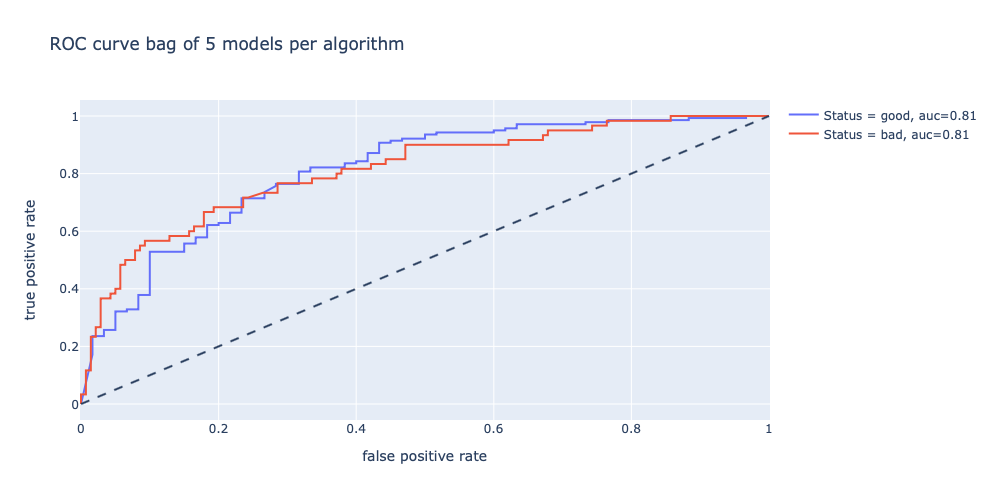

accuracy_score: 0.805


In [66]:
n = 5
ys, dnnInfo = bagging(X_train, y_train, X_test, y_test, n=n, frac=1)
y_pred = avgYs(ys)
cm, summary = analize(y_pred, y_test, f'bag of {n} models per algorithm')
bagging_experiment[f'n={n}, frac=1'] = {'cm':cm.copy(), 'summary':summary.copy()}

In [67]:
cm

true 0  true 1
pred 0     131      30
pred 1       9      30

In [68]:
summary

metric     value
0  Sensitivity  0.935714
1       Recall  0.935714
2  Specificity  0.500000
3    Precision  0.813665
4     Accuracy  0.805000
5      F1Score  0.870432

# Baggin of 10 models per algo., frac = 1

[02:21:57] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:22:42] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:23:28] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:24:14] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

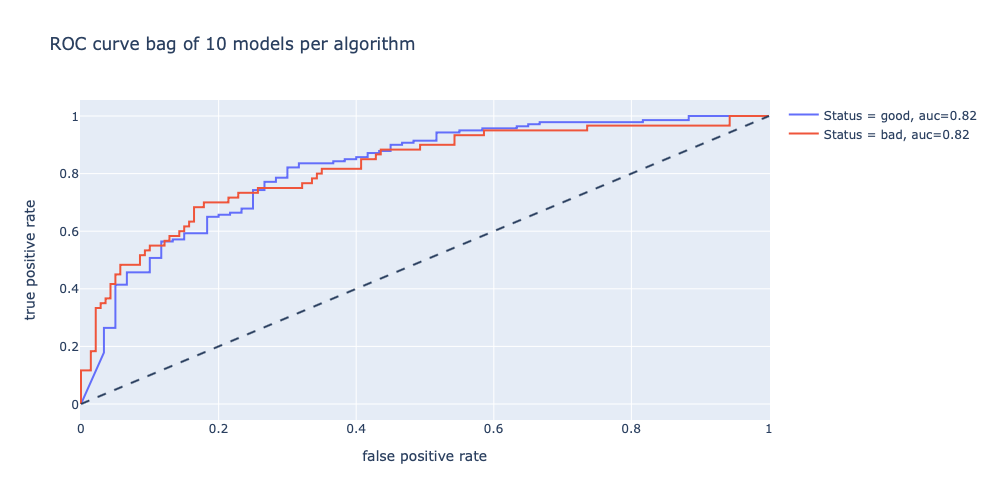

accuracy_score: 0.795


In [69]:
n = 10
ys, dnnInfo = bagging(X_train, y_train, X_test, y_test, n=n, frac=1)
y_pred = avgYs(ys)
cm, summary = analize(y_pred, y_test, f'bag of {n} models per algorithm')
bagging_experiment[f'n={n}, frac=1'] = {'cm':cm.copy(), 'summary':summary.copy()}

In [70]:
cm

true 0  true 1
pred 0     130      31
pred 1      10      29

In [71]:
summary

metric     value
0  Sensitivity  0.928571
1       Recall  0.928571
2  Specificity  0.483333
3    Precision  0.807453
4     Accuracy  0.795000
5      F1Score  0.863787

# Baggin of 15 models per algo., frac = 1

In [72]:
n = 15
ys, dnnInfo = bagging(X_train, y_train, X_test, y_test, n=n, frac=1)
y_pred = avgYs(ys)
cm, summary = analize(y_pred, y_test, f'bag of {n} models per algorithm')
bagging_experiment[f'n={n}, frac=1'] = {'cm':cm.copy(), 'summary':summary.copy()}

[02:29:32] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:30:18] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:31:03] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:31:49] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

accuracy_score: 0.8


In [73]:
cm

true 0  true 1
pred 0     131      31
pred 1       9      29

In [74]:
summary

metric     value
0  Sensitivity  0.935714
1       Recall  0.935714
2  Specificity  0.483333
3    Precision  0.808642
4     Accuracy  0.800000
5      F1Score  0.867550

# Baggin of 20 models per algo., frac = 1

In [75]:
n = 20
ys, dnnInfo = bagging(X_train, y_train, X_test, y_test, n=n, frac=1)
y_pred = avgYs(ys)
cm, summary = analize(y_pred, y_test, f'bag of {n} models per algorithm')
bagging_experiment[f'n={n}, frac=1'] = {'cm':cm.copy(), 'summary':summary.copy()}

[02:40:58] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:41:44] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:42:30] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:43:15] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

accuracy_score: 0.79


In [76]:
cm

true 0  true 1
pred 0     129      31
pred 1      11      29

In [77]:
summary

metric     value
0  Sensitivity  0.921429
1       Recall  0.921429
2  Specificity  0.483333
3    Precision  0.806250
4     Accuracy  0.790000
5      F1Score  0.860000

# Baggin of 25 models per algo., frac = 1

[02:56:12] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:56:58] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:57:44] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:58:30] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

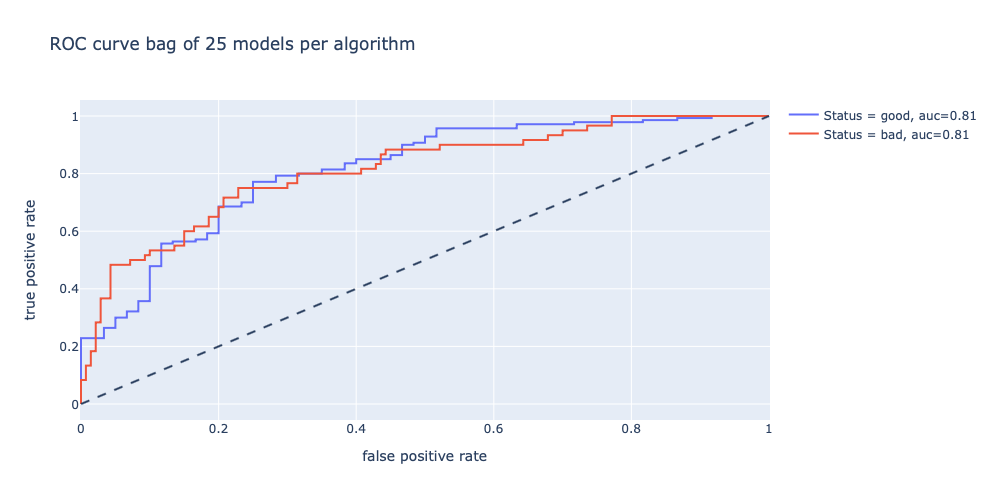

accuracy_score: 0.795


In [78]:
n = 25
ys, dnnInfo = bagging(X_train, y_train, X_test, y_test, n=n, frac=1)
y_pred = avgYs(ys)
cm, summary = analize(y_pred, y_test, f'bag of {n} models per algorithm')
bagging_experiment[f'n={n}, frac=1'] = {'cm':cm.copy(), 'summary':summary.copy()}

In [79]:
cm

true 0  true 1
pred 0     130      31
pred 1      10      29

In [80]:
summary

metric     value
0  Sensitivity  0.928571
1       Recall  0.928571
2  Specificity  0.483333
3    Precision  0.807453
4     Accuracy  0.795000
5      F1Score  0.863787

# Baggin of 30 models per algo., frac = 1

[03:15:19] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:16:05] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:16:50] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:17:36] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

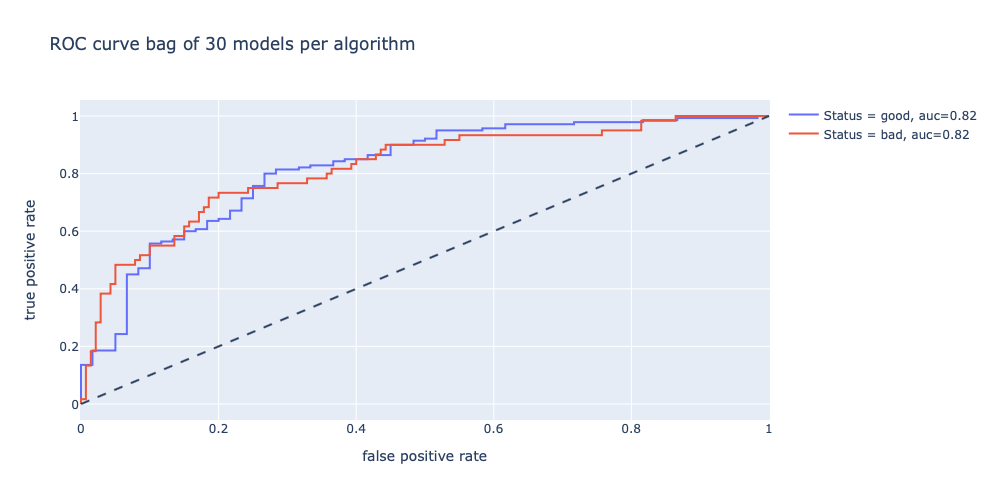

accuracy_score: 0.79


In [81]:
n = 30
ys, dnnInfo = bagging(X_train, y_train, X_test, y_test, n=n, frac=1)
y_pred = avgYs(ys)
cm, summary = analize(y_pred, y_test, f'bag of {n} models per algorithm')
bagging_experiment[f'n={n}, frac=1'] = {'cm':cm.copy(), 'summary':summary.copy()}

In [82]:
cm

true 0  true 1
pred 0     129      31
pred 1      11      29

In [83]:
summary

metric     value
0  Sensitivity  0.921429
1       Recall  0.921429
2  Specificity  0.483333
3    Precision  0.806250
4     Accuracy  0.790000
5      F1Score  0.860000

# Baggin of 5 models per algo., frac = 0.75

[03:37:57] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:38:25] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:38:53] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:39:21] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

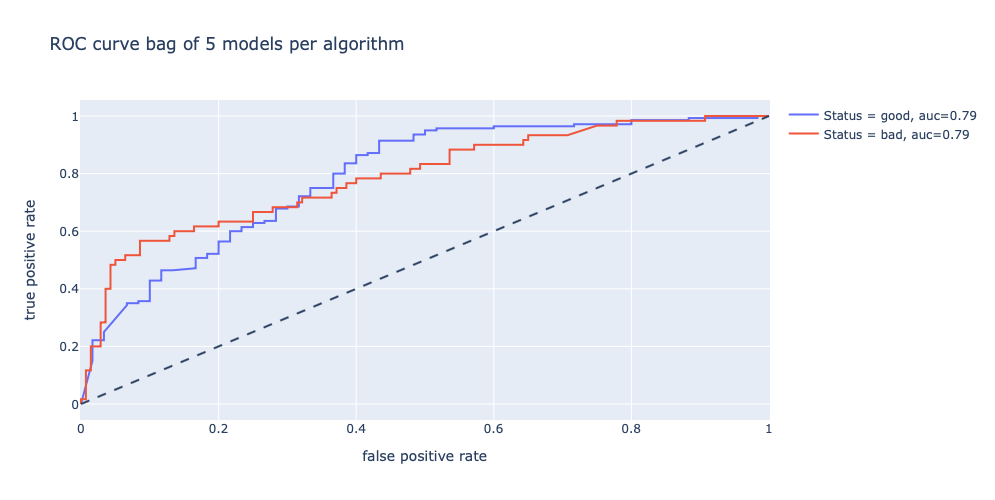

accuracy_score: 0.81


In [84]:
n = 5
ys, dnnInfo = bagging(X_train, y_train, X_test, y_test, n=n)
y_pred = avgYs(ys)
cm, summary = analize(y_pred, y_test, f'bag of {n} models per algorithm')
bagging_experiment[f'n={n}, frac=0.75'] = {'cm':cm.copy(), 'summary':summary.copy()}

In [85]:
cm

true 0  true 1
pred 0     134      32
pred 1       6      28

In [86]:
summary

metric     value
0  Sensitivity  0.957143
1       Recall  0.957143
2  Specificity  0.466667
3    Precision  0.807229
4     Accuracy  0.810000
5      F1Score  0.875817

# Bagging of 10 models per algo. frac = 0.75

[03:40:17] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:40:46] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:41:14] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:41:42] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

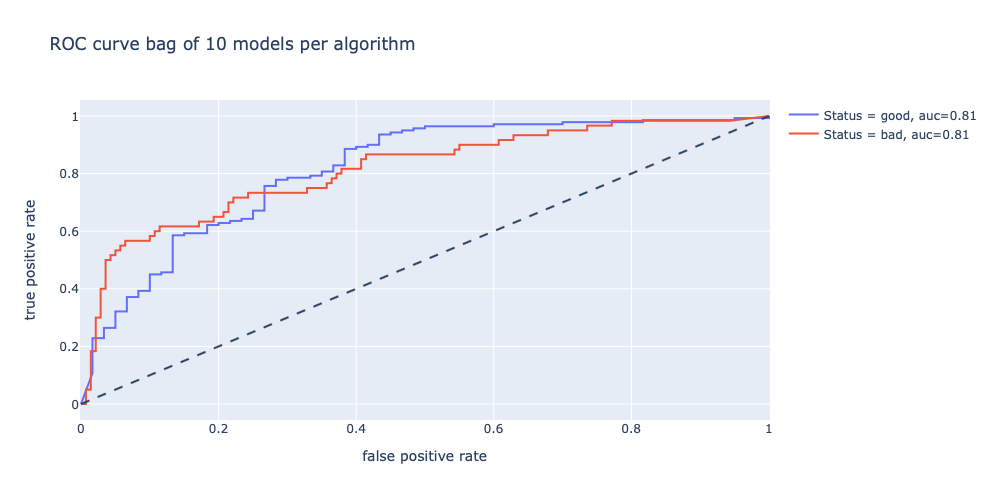

accuracy_score: 0.82


In [87]:
n=10
ys, dnnInfo = bagging(X_train, y_train, X_test, y_test, n=n)
y_pred = avgYs(ys)
cm, summary = analize(y_pred, y_test, f'bag of {n} models per algorithm')
bagging_experiment[f'n={n}, frac=0.75'] = {'cm':cm.copy(), 'summary':summary.copy()}

In [88]:
cm

true 0  true 1
pred 0     135      31
pred 1       5      29

In [89]:
summary

metric     value
0  Sensitivity  0.964286
1       Recall  0.964286
2  Specificity  0.483333
3    Precision  0.813253
4     Accuracy  0.820000
5      F1Score  0.882353

# Bagging of 15 models per algo. frac = 0.75

[03:45:00] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:45:28] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:45:56] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:46:24] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

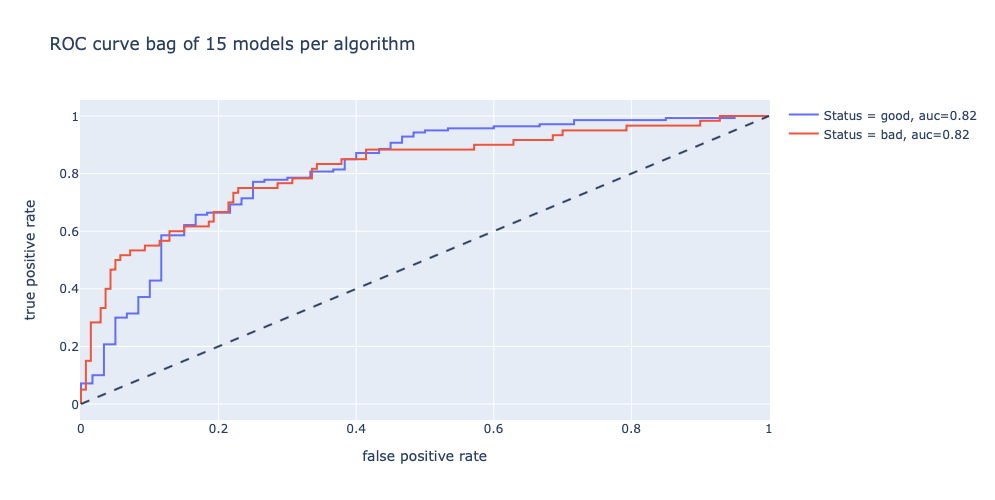

accuracy_score: 0.805


In [90]:
n=15
ys, dnnInfo = bagging(X_train, y_train, X_test, y_test, n=n)
y_pred = avgYs(ys)
cm, summary = analize(y_pred, y_test, f'bag of {n} models per algorithm')
bagging_experiment[f'n={n}, frac=0.75'] = {'cm':cm.copy(), 'summary':summary.copy()}

In [91]:
cm

true 0  true 1
pred 0     134      33
pred 1       6      27

In [92]:
summary

metric     value
0  Sensitivity  0.957143
1       Recall  0.957143
2  Specificity  0.450000
3    Precision  0.802395
4     Accuracy  0.805000
5      F1Score  0.872964

# Bagging of 20 models per algo. frac = 0.75

[03:52:03] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:52:31] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:52:59] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:53:28] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

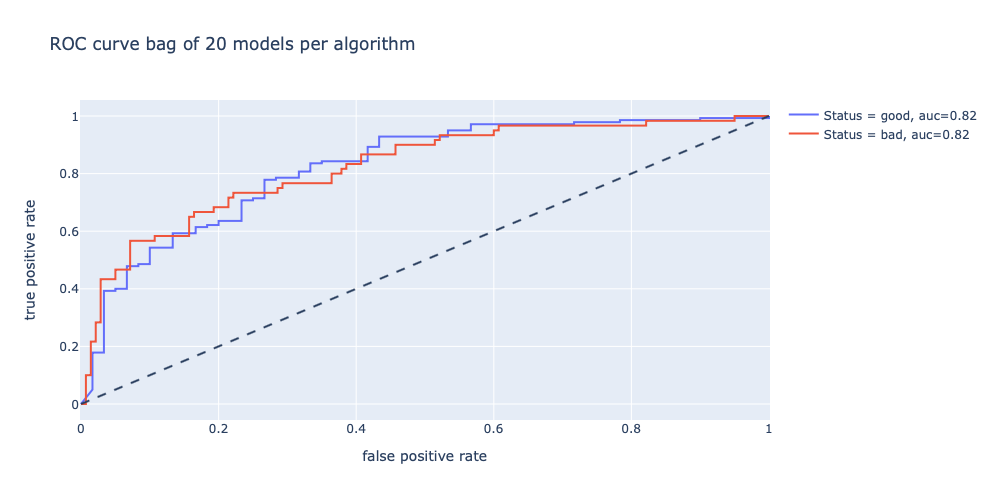

accuracy_score: 0.795


In [93]:
n=20
ys, dnnInfo = bagging(X_train, y_train, X_test, y_test, n=n)
y_pred = avgYs(ys)
cm, summary = analize(y_pred, y_test, f'bag of {n} models per algorithm')
bagging_experiment[f'n={n}, frac=0.75'] = {'cm':cm.copy(), 'summary':summary.copy()}

In [94]:
cm

true 0  true 1
pred 0     133      34
pred 1       7      26

In [95]:
summary

metric     value
0  Sensitivity  0.950000
1       Recall  0.950000
2  Specificity  0.433333
3    Precision  0.796407
4     Accuracy  0.795000
5      F1Score  0.866450

# Bagging of 25 models per algo. frac = 0.75

[04:01:28] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:01:56] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:02:25] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:02:53] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

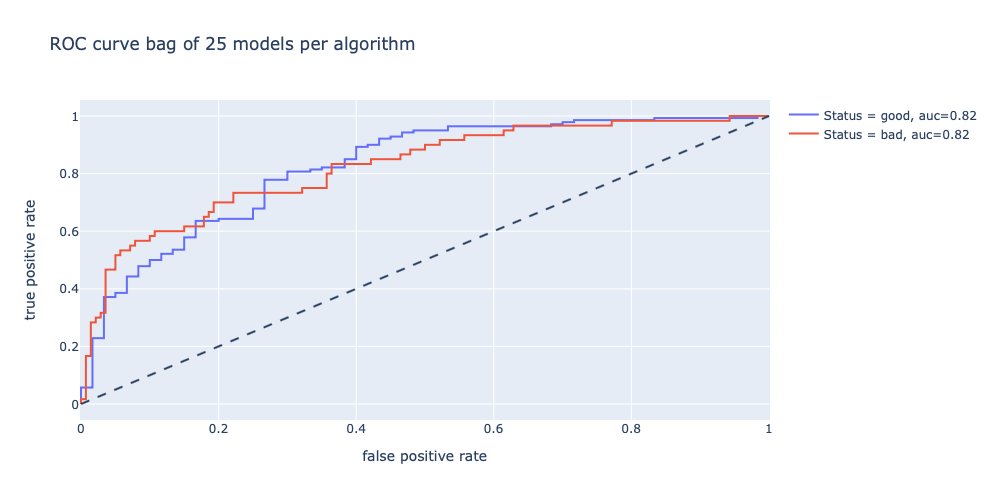

accuracy_score: 0.815


In [96]:
n=25
ys, dnnInfo = bagging(X_train, y_train, X_test, y_test, n=n)
y_pred = avgYs(ys)
cm, summary = analize(y_pred, y_test, f'bag of {n} models per algorithm')
bagging_experiment[f'n={n}, frac=0.75'] = {'cm':cm.copy(), 'summary':summary.copy()}

In [97]:
cm

true 0  true 1
pred 0     135      32
pred 1       5      28

In [98]:
summary

metric     value
0  Sensitivity  0.964286
1       Recall  0.964286
2  Specificity  0.466667
3    Precision  0.808383
4     Accuracy  0.815000
5      F1Score  0.879479

# Bagging of 30 models per algo. frac = 0.75

In [99]:
n = 30
ys, dnnInfo = bagging(X_train, y_train, X_test, y_test, n=n)
y_pred = avgYs(ys)
cm, summary = analize(y_pred, y_test, f'bag of {n} models per algorithm')
bagging_experiment[f'n={n}, frac=0.75'] = {'cm':cm.copy(), 'summary':summary.copy()}

[04:13:15] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:13:44] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:14:12] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:14:40] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

accuracy_score: 0.805


In [100]:
cm

true 0  true 1
pred 0     132      31
pred 1       8      29

In [101]:
summary

metric     value
0  Sensitivity  0.942857
1       Recall  0.942857
2  Specificity  0.483333
3    Precision  0.809816
4     Accuracy  0.805000
5      F1Score  0.871287

# Baggin of 5 models per algo., frac = 0.5

In [102]:
n = 5
ys, dnnInfo = bagging(X_train, y_train, X_test, y_test, n=n, frac=0.5)
y_pred = avgYs(ys)
cm, summary = analize(y_pred, y_test, f'bag of {n} models per algorithm')
bagging_experiment[f'n={n}, frac=0.5'] = {'cm':cm.copy(), 'summary':summary.copy()}

[04:27:10] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:27:25] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:27:39] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:27:54] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

accuracy_score: 0.79


In [103]:
cm

true 0  true 1
pred 0     132      34
pred 1       8      26

In [104]:
summary

metric     value
0  Sensitivity  0.942857
1       Recall  0.942857
2  Specificity  0.433333
3    Precision  0.795181
4     Accuracy  0.790000
5      F1Score  0.862745

# Baggin of 10 models per algo., frac = 0.5

[04:28:24] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:28:38] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:28:53] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:29:08] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

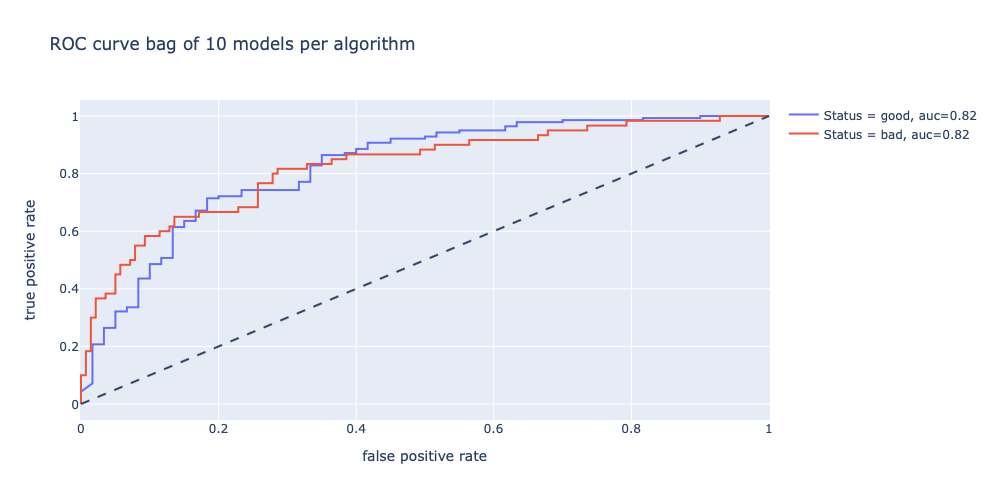

accuracy_score: 0.8


In [105]:
n = 10
ys, dnnInfo = bagging(X_train, y_train, X_test, y_test, n=n, frac=0.5)
y_pred = avgYs(ys)
cm, summary = analize(y_pred, y_test, f'bag of {n} models per algorithm')
bagging_experiment[f'n={n}, frac=0.5'] = {'cm':cm.copy(), 'summary':summary.copy()}

In [106]:
cm

true 0  true 1
pred 0     132      32
pred 1       8      28

In [107]:
summary

metric     value
0  Sensitivity  0.942857
1       Recall  0.942857
2  Specificity  0.466667
3    Precision  0.804878
4     Accuracy  0.800000
5      F1Score  0.868421

# Baggin of 15 models per algo., frac = 0.5

[04:30:51] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:31:06] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:31:21] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:31:35] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

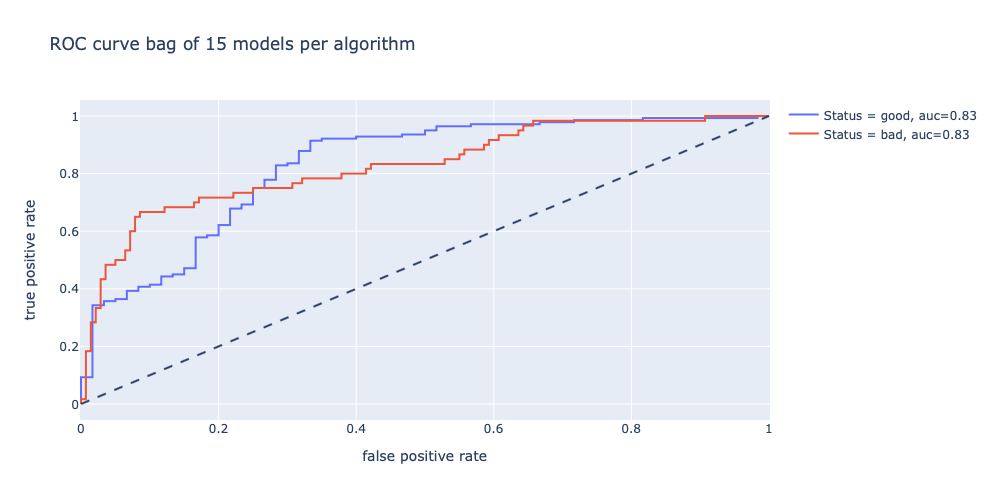

accuracy_score: 0.81


In [108]:
n = 15
ys, dnnInfo = bagging(X_train, y_train, X_test, y_test, n=n, frac=0.5)
y_pred = avgYs(ys)
cm, summary = analize(y_pred, y_test, f'bag of {n} models per algorithm')
bagging_experiment[f'n={n}, frac=0.5'] = {'cm':cm.copy(), 'summary':summary.copy()}

In [109]:
cm

true 0  true 1
pred 0     136      34
pred 1       4      26

In [110]:
summary

metric     value
0  Sensitivity  0.971429
1       Recall  0.971429
2  Specificity  0.433333
3    Precision  0.800000
4     Accuracy  0.810000
5      F1Score  0.877419

# Baggin of 20 models per algo., frac = 0.5

[04:34:33] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:34:47] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:35:02] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:35:17] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

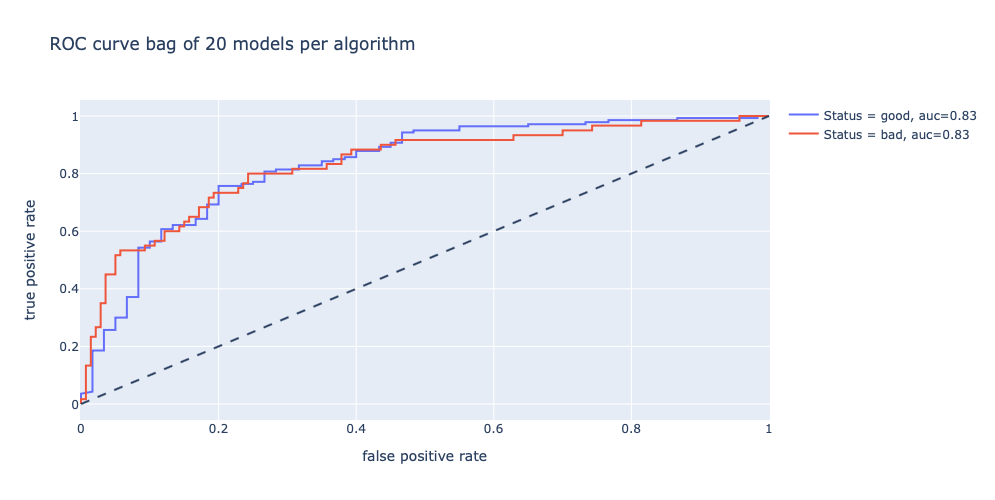

accuracy_score: 0.805


In [111]:
n = 20
ys, dnnInfo = bagging(X_train, y_train, X_test, y_test, n=n, frac=0.5)
y_pred = avgYs(ys)
cm, summary = analize(y_pred, y_test, f'bag of {n} models per algorithm')
bagging_experiment[f'n={n}, frac=0.5'] = {'cm':cm.copy(), 'summary':summary.copy()}

In [112]:
cm

true 0  true 1
pred 0     134      33
pred 1       6      27

In [113]:
summary

metric     value
0  Sensitivity  0.957143
1       Recall  0.957143
2  Specificity  0.450000
3    Precision  0.802395
4     Accuracy  0.805000
5      F1Score  0.872964

# Baggin of 25 models per algo., frac = 0.5

[04:39:27] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:39:42] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:39:56] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:40:11] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

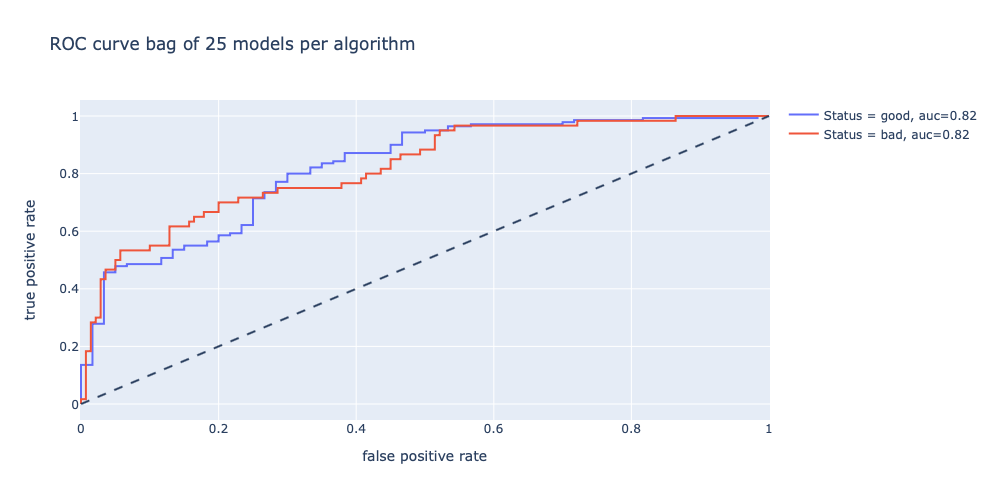

accuracy_score: 0.81


In [114]:
n = 25
ys, dnnInfo = bagging(X_train, y_train, X_test, y_test, n=n, frac=0.5)
y_pred = avgYs(ys)
cm, summary = analize(y_pred, y_test, f'bag of {n} models per algorithm')
bagging_experiment[f'n={n}, frac=0.5'] = {'cm':cm.copy(), 'summary':summary.copy()}

In [115]:
cm

true 0  true 1
pred 0     134      32
pred 1       6      28

In [116]:
summary

metric     value
0  Sensitivity  0.957143
1       Recall  0.957143
2  Specificity  0.466667
3    Precision  0.807229
4     Accuracy  0.810000
5      F1Score  0.875817

# Baggin of 30 models per algo., frac = 0.5

[04:45:35] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:45:50] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:46:04] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:46:19] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

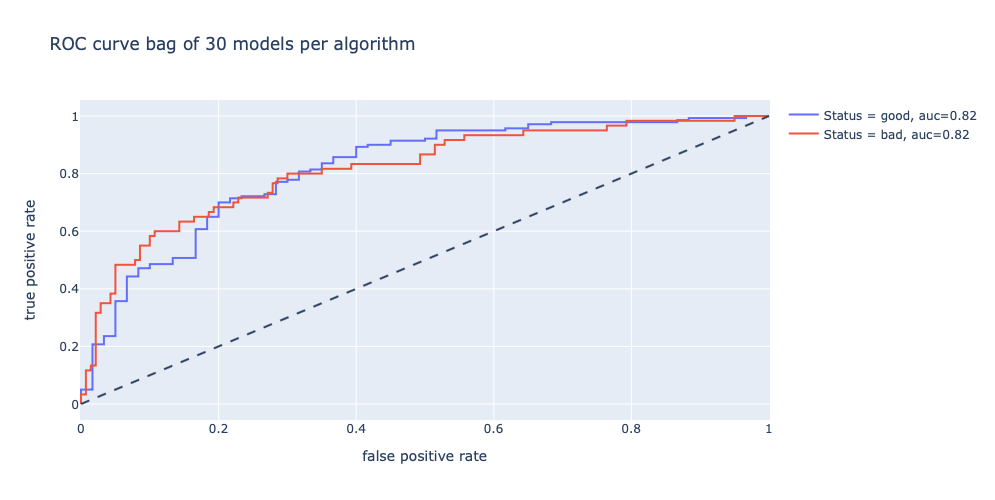

accuracy_score: 0.78


In [117]:
n = 30
ys, dnnInfo = bagging(X_train, y_train, X_test, y_test, n=n, frac=0.5)
y_pred = avgYs(ys)
cm, summary = analize(y_pred, y_test, f'bag of {n} models per algorithm')
bagging_experiment[f'n={n}, frac=0.5'] = {'cm':cm.copy(), 'summary':summary.copy()}

In [118]:
cm

true 0  true 1
pred 0     133      37
pred 1       7      23

In [119]:
summary

metric     value
0  Sensitivity  0.950000
1       Recall  0.950000
2  Specificity  0.383333
3    Precision  0.782353
4     Accuracy  0.780000
5      F1Score  0.858065

# Baggin of 5 models per algo., frac = 0.25

[04:52:48] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:52:53] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:52:59] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:53:05] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

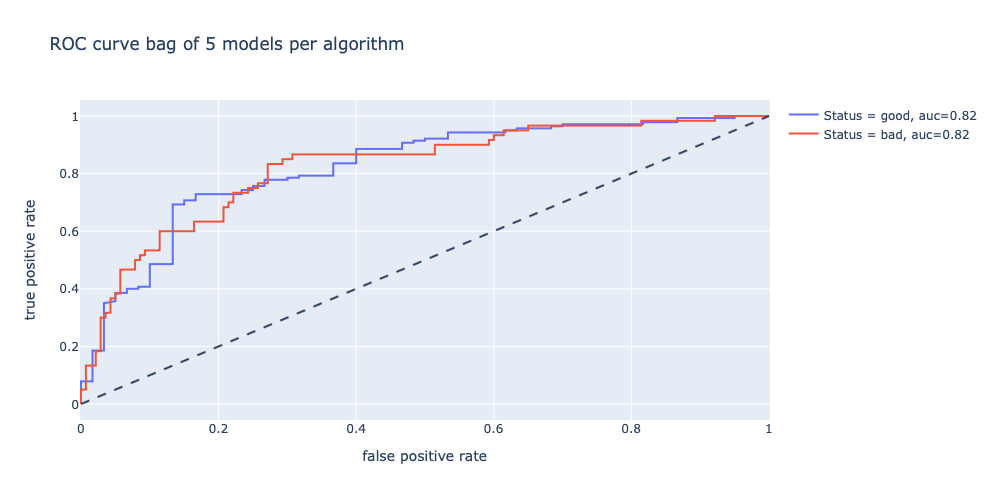

accuracy_score: 0.78


In [120]:
n = 5
ys, dnnInfo = bagging(X_train, y_train, X_test, y_test, n=n, frac=0.25)
y_pred = avgYs(ys)
cm, summary = analize(y_pred, y_test, f'bag of {n} models per algorithm')
bagging_experiment[f'n={n}, frac=0.25'] = {'cm':cm.copy(), 'summary':summary.copy()}

In [121]:
cm

true 0  true 1
pred 0     133      37
pred 1       7      23

In [122]:
summary

metric     value
0  Sensitivity  0.950000
1       Recall  0.950000
2  Specificity  0.383333
3    Precision  0.782353
4     Accuracy  0.780000
5      F1Score  0.858065

# Baggin of 10 models per algo., frac = 0.25

[04:53:16] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:53:21] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:53:27] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:53:32] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

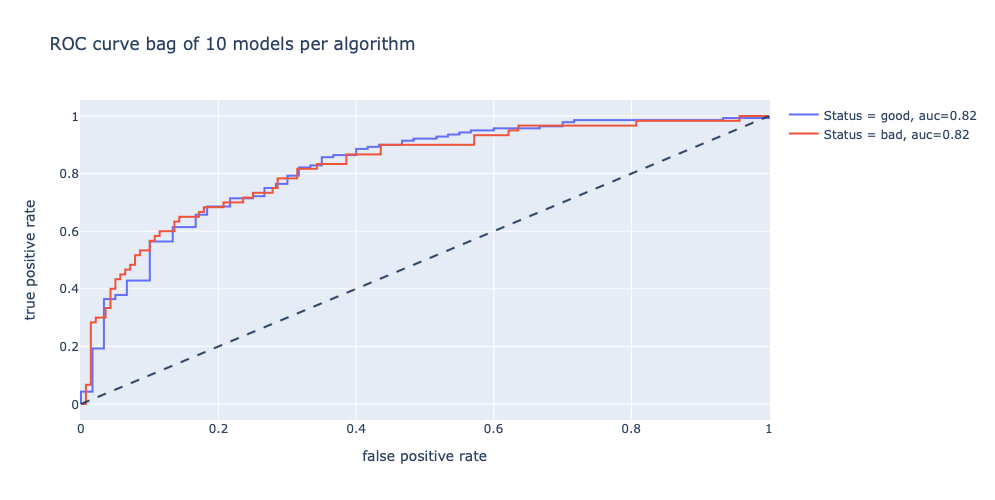

accuracy_score: 0.795


In [123]:
n = 10
ys, dnnInfo = bagging(X_train, y_train, X_test, y_test, n=n, frac=0.25)
y_pred = avgYs(ys)
cm, summary = analize(y_pred, y_test, f'bag of {n} models per algorithm')
bagging_experiment[f'n={n}, frac=0.25'] = {'cm':cm.copy(), 'summary':summary.copy()}

In [124]:
cm

true 0  true 1
pred 0     132      33
pred 1       8      27

In [125]:
summary

metric     value
0  Sensitivity  0.942857
1       Recall  0.942857
2  Specificity  0.450000
3    Precision  0.800000
4     Accuracy  0.795000
5      F1Score  0.865574

# Baggin of 15 models per algo., frac = 0.25

[04:54:10] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:54:16] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:54:21] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:54:27] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

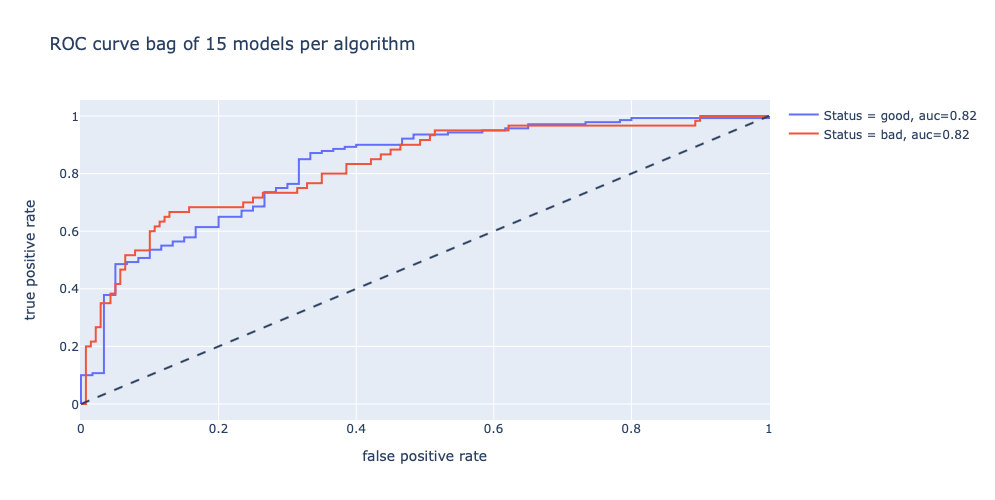

accuracy_score: 0.785


In [126]:
n = 15
ys, dnnInfo = bagging(X_train, y_train, X_test, y_test, n=n, frac=0.25)
y_pred = avgYs(ys)
cm, summary = analize(y_pred, y_test, f'bag of {n} models per algorithm')
bagging_experiment[f'n={n}, frac=0.25'] = {'cm':cm.copy(), 'summary':summary.copy()}

In [127]:
cm

true 0  true 1
pred 0     134      37
pred 1       6      23

In [128]:
summary

metric     value
0  Sensitivity  0.957143
1       Recall  0.957143
2  Specificity  0.383333
3    Precision  0.783626
4     Accuracy  0.785000
5      F1Score  0.861736

# Baggin of 20 models per algo., frac = 0.25

[04:55:32] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:55:38] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:55:43] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:55:49] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

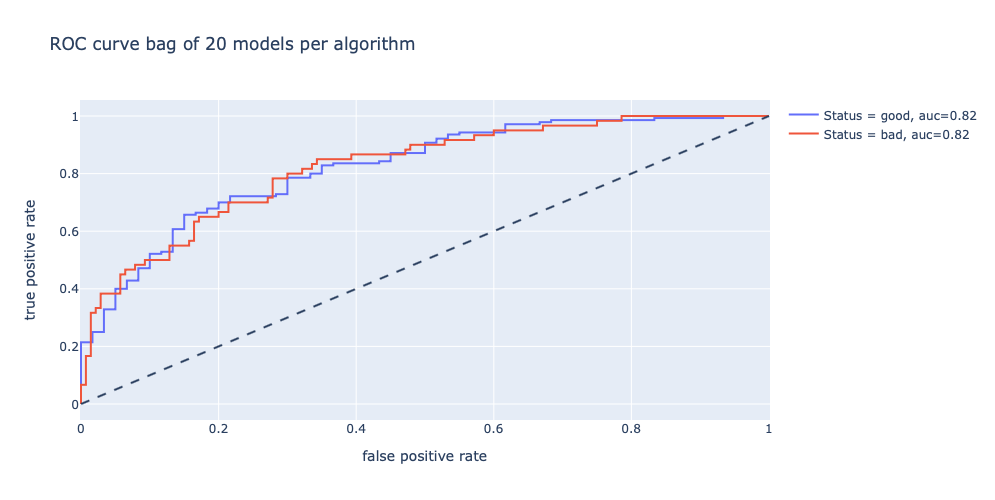

accuracy_score: 0.78


In [129]:
n = 20
ys, dnnInfo = bagging(X_train, y_train, X_test, y_test, n=n, frac=0.25)
y_pred = avgYs(ys)
cm, summary = analize(y_pred, y_test, f'bag of {n} models per algorithm')
bagging_experiment[f'n={n}, frac=0.25'] = {'cm':cm.copy(), 'summary':summary.copy()}

In [130]:
cm

true 0  true 1
pred 0     132      36
pred 1       8      24

In [131]:
summary

metric     value
0  Sensitivity  0.942857
1       Recall  0.942857
2  Specificity  0.400000
3    Precision  0.785714
4     Accuracy  0.780000
5      F1Score  0.857143

# Baggin of 25 models per algo., frac = 0.25

[04:57:21] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:57:27] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:57:32] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:57:38] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

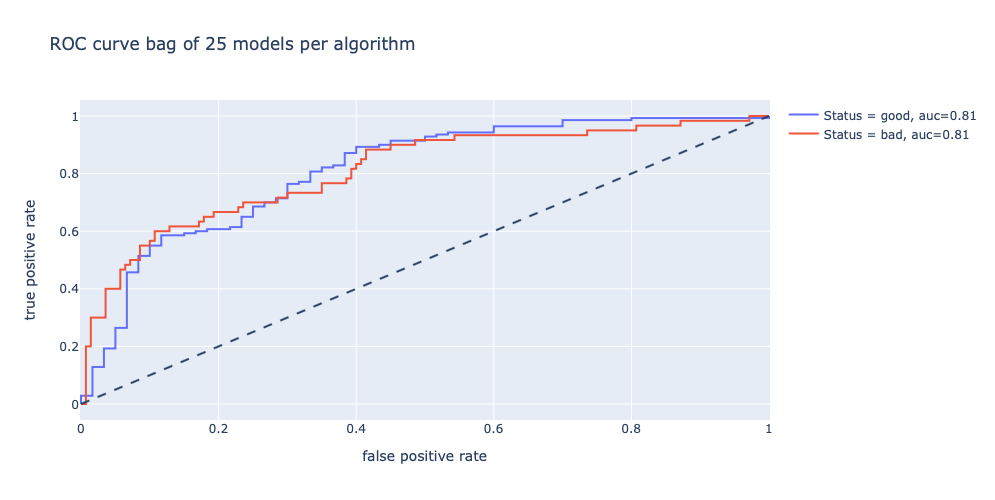

accuracy_score: 0.775


In [132]:
n = 25
ys, dnnInfo = bagging(X_train, y_train, X_test, y_test, n=n, frac=0.25)
y_pred = avgYs(ys)
cm, summary = analize(y_pred, y_test, f'bag of {n} models per algorithm')
bagging_experiment[f'n={n}, frac=0.25'] = {'cm':cm.copy(), 'summary':summary.copy()}

In [133]:
cm

true 0  true 1
pred 0     135      40
pred 1       5      20

In [134]:
summary

metric     value
0  Sensitivity  0.964286
1       Recall  0.964286
2  Specificity  0.333333
3    Precision  0.771429
4     Accuracy  0.775000
5      F1Score  0.857143

# Baggin of 30 models per algo., frac = 0.25

[04:59:38] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:59:43] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:59:49] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:59:54] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

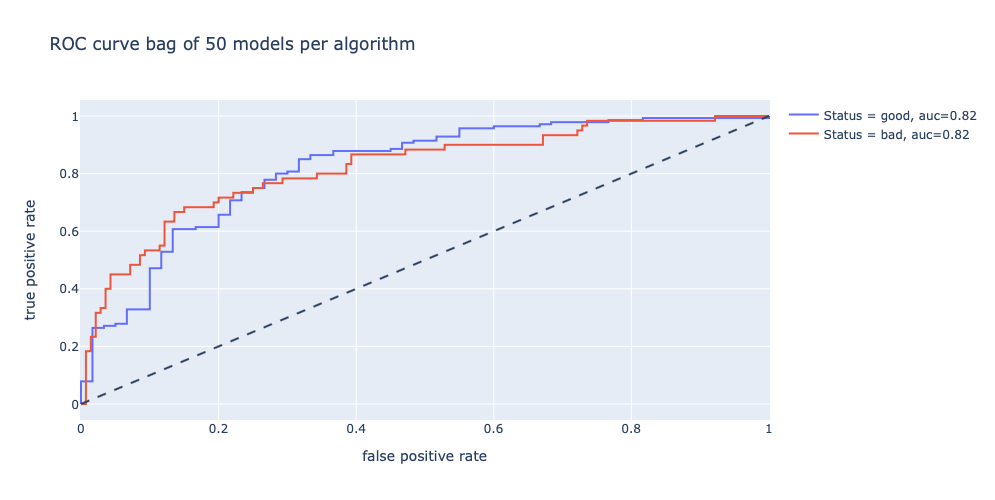

accuracy_score: 0.79


In [135]:
n = 50
ys, dnnInfo = bagging(X_train, y_train, X_test, y_test, n=n, frac=0.25)
y_pred = avgYs(ys)
cm, summary = analize(y_pred, y_test, f'bag of {n} models per algorithm')
bagging_experiment[f'n={n}, frac=0.25'] = {'cm':cm.copy(), 'summary':summary.copy()}

In [136]:
cm

true 0  true 1
pred 0     134      36
pred 1       6      24

In [137]:
summary

metric     value
0  Sensitivity  0.957143
1       Recall  0.957143
2  Specificity  0.400000
3    Precision  0.788235
4     Accuracy  0.790000
5      F1Score  0.864516

# Save experiment result

In [139]:
pkl.dump(bagging_experiment, open('baggingExp.pkl', 'wb'))

# Bagging Result

In [140]:
# e = bagging_experiment
# e.keys()

In [141]:
# e['origin']['cm']

In [142]:

# experiment = {'origin':[1, 100,
#                         e['origin']['cm'].loc['pred 0','true 0'], 
#                         e['origin']['cm'].loc['pred 0','true 1'], 
#                         e['origin']['cm'].loc['pred 1','true 0'], 
#                         e['origin']['cm'].loc['pred 1','true 1'], 
#                         e['origin']['summary'].loc[0, 'value'], 
#                         e['origin']['summary'].loc[1, 'value'], 
#                         e['origin']['summary'].loc[2, 'value'], 
#                         e['origin']['summary'].loc[3, 'value'], 
#                         e['origin']['summary'].loc[4, 'value'], 
#                         e['origin']['summary'].loc[5, 'value']
#                        ]}

# for key in e.keys():
#     if key == 'origin':
#         continue
#     else:
#         n = int(key.split(', ')[0].split('=')[-1])
#         frac = int(float(key.split(', ')[1].split('=')[-1])*100)
#         experiment[key] = [n, frac, e[key]['cm'].loc['pred 0','true 0'], 
#                                     e[key]['cm'].loc['pred 0','true 1'], 
#                                     e[key]['cm'].loc['pred 1','true 0'], 
#                                     e[key]['cm'].loc['pred 1','true 1'], 
#                                     e[key]['summary'].loc[0, 'value'], 
#                                     e[key]['summary'].loc[1, 'value'], 
#                                     e[key]['summary'].loc[2, 'value'], 
#                                     e[key]['summary'].loc[3, 'value'], 
#                                     e[key]['summary'].loc[4, 'value'], 
#                                     e[key]['summary'].loc[5, 'value']]
        
# experiment = pd.DataFrame(experiment, index=['n', 'frac', 'pred 0|true 0','pred 0|true 1', 
#                                              'pred 1|true 0', 'pred 1|true 1', 'Sensitivity', 
#                                              'Recall', 'Specificity', 'Precision', 'Accuracy', 
#                                              'F1Score']).T

In [143]:
# def plotExpSummary(col)
#     trace1 = {
#       'name': f'frac=75%', 
#       'type': 'scatter', 
#       'x': [5, 10, 20, 30, 40, 50], 
#       'y': experiment[experiment.frac==75][[col]].values.reshape((-1,)).tolist()
#     }
#     trace2 = {
#       'name': f'frac=50%', 
#       'type': 'scatter', 
#       'x': [5, 10, 20, 30, 40, 50], 
#       'y': experiment[experiment.frac==50][[col]].values.reshape((-1,)).tolist()
#     }
#     trace3 = {
#       'name': f'frac=25%', 
#       'type': 'scatter', 
#       'x': [5, 10, 20, 30, 40, 50], 
#       'y': experiment[experiment.frac==25][[col]].values.reshape((-1,)).tolist()
#     }

#     data = [trace1, trace2, trace3]
#     layout = {
#       'title': f'Ensemble Under Various Settings', 
#       'xaxis': {
#         'title': 'Number of Models per Algorithm', 
#         'zeroline': False
#       }, 
#       'yaxis': {
#         'title': 'Sample Rate', 
#         'zeroline': False,
#       },
#     }

#     fig = Figure(data=data, layout=layout)
#     py.iplot(fig, validate = False)